# Investigating Rideshare Usage Patterns With KMeans Clustering


**Background**

Since November 2018, rideshare providers (Lyft, Uber, etc) operating in Chicago are required by ordinance to submit periodic data reports with basic rideshare information to the City.  The main [Trips dataset](https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips/m6dm-c72p) includes information about individual rides, including starting and ending times and locations, fares and tips, and whether the rides were pooled.  The Trips data are anonymized, so trip starting and ending locations are generalized to the nearest census tract, and drivers cannot be linked to particular rides they provided.  The portion of the dataset used for this exercise covers November 2018 through March 2019.

To prepare for the analyses and visualizations in this notebook, the Trips data was cleaned, aggregated, and enriched with climate and census data.  A preliminary exploration of this dataset is available [here](https://github.com/LisaATaylor/Rideshare/blob/master/Chicago%20Rideshare%20Data%20Story.ipynb).  The steps taken to process and prepare the rideshare dataset are in the following file [here](https://github.com/LisaATaylor/Rideshare/blob/master/RideshareDataPrep.py).

**Clustering Evaluation**

The main question explored by this notebook is whether clustering algorithms can be applied to identify common rideshare usage patterns.  By clustering rideshare usage by consumer behavior patterns, we can identify which routes within the city are utilized in similar ways.  For this analysis I've used the Community Area to spatially aggregate ride counts, rather than the census tract, to reduce the number of potential routes in the analysis.  A map of Community Areas can be found here: https://en.wikipedia.org/wiki/Community_areas_in_Chicago



1.  [Setup and Data Loading](#setup)
2.  [Data Inspection and Reworking](#look)
3.  [Application of K-Means - Select K](#pick_k)
4.  [Fit K-Means Model](#fit)
5.  [Visualization of Results](#viz)
6.  [Summary of Findings](#findings)


<a id='setup'></a>

---

## 1.  Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import os


In [2]:
plt.rcParams['figure.figsize'] = [15, 5]
sns.set()
import warnings; warnings.simplefilter('ignore')

In [6]:
#load data 
datadir=r'/Users/rtaylor/Desktop/Springboard/DataSets/Rideshare'

samp_df_enhanced=pd.read_pickle(os.path.join(datadir,'cleaned_all'))

In [7]:
#Inspect the post-processed data
#The dataset is the original Chicago Trips data enhanced with several derived fields
samp_df_enhanced.iloc[0]

TripStart                               2018-11-23 19:00:00
TripEnd                                 2018-11-23 19:15:00
TripSeconds                                            1009
TripMiles                                               4.5
PUCensusTract                                   17031240900
DOCensusTract                                   17031831900
PUCommunityArea                                          24
DOCommunityArea                                           6
Fare                                                     10
Tip                                                       0
AdditionalCharges                                       2.5
TripTotal                                              12.5
SharedTripAuth                                        False
TripsPooled                                               1
PU_Lat                                              41.9047
PU_Long                                            -87.7019
PU_Geo                 POINT (-87.701884

<a id='look'></a>

##  2.  Data Inspection and Reworking
What insight can be gained regarding rideshare user patterns in Chicago without applying a clustering model?  Simple grouping and sorting can reveal major patterns.

In [8]:
#Try grouping to see frequent patterns
subset_df=samp_df_enhanced.loc[~samp_df_enhanced.IsHoliday,['PUCommunityArea','DOCommunityArea','DayPeriod','RideLength','IsWeekend','Fare','TripMiles','AirportDOorPU']]
subset_df_grouped=subset_df.groupby(['PUCommunityArea','DOCommunityArea','DayPeriod','RideLength','IsWeekend','AirportDOorPU']).agg({'Fare':['mean','std','size'],'TripMiles':'mean'})
subset_df_grouped=subset_df_grouped.reset_index()
subset_df_grouped.columns=['PUCommunityArea','DOCommunityArea','DayPeriod','RideLength','IsWeekend','IsAirport','MeanFare','STDFare','NumRides','MeanDist']
subset_df_grouped.sort_values('NumRides',ascending=False,inplace=True)


In [9]:
subset_df_grouped.head(10)
#we see that most common rides are short rides occurring in the morning and evening hours near downtown (Community Area 32)

PUCommunityArea  DOCommunityArea  DayPeriod RideLength  IsWeekend  \
54804               8.0             32.0    morning        1-5      False   
52448               8.0              8.0    evening        0-1      False   
54420               8.0             28.0    morning        1-5      False   
229860             32.0              8.0    evening        1-5      False   
52452               8.0              8.0    evening        1-5      False   
229828             32.0              8.0  afternoon        1-5      False   
200292             28.0              8.0    evening        1-5      False   
54372               8.0             28.0    evening        1-5      False   
54788               8.0             32.0     midday        1-5      False   
52500               8.0              8.0    morning        1-5      False   

        IsAirport  MeanFare   STDFare  NumRides  MeanDist  
54804       False  6.685086  2.432106   14161.0  1.769218  
52448       False  4.577338  1.885586    7784.0  0.725501  
54420       False  7.395069  2.659788    7362.0  2.296781  
229860      False  6.644689  2.571372    6939.0  1.816645  
52452       False  5.941909  2.092463    6662.0  1.534884  
229828      False  7.039043  2.915555    6416.0  1.786347  
200292      False  7.232217  2.729156    6059.0  2.374121  
54372       False  7.820556  3.097419    5896.0  2.452069  
54788       False  6.329416  1.944674    5871.0  1.788145  
52500       False  5.805714  1.976776    5793.0  1.547298

### Reworking the data for input to clustering algorithm
Here I re-group the data so that each record shows ride counts for a particular route (i.e. unique combination of pickup and dropoff Community Areas) during different times of day, weekend vs weekday, average distance for routes between those areas, and whether either Community Area is an airport.  Rides on holidays have been removed from the dataset.

In [10]:
subset_df=samp_df_enhanced.loc[~samp_df_enhanced.IsHoliday,['PUCommunityArea','DOCommunityArea','DayPeriod','IsWeekend','Fare','AirportDOorPU']]
subset_df_grouped=subset_df.groupby(['PUCommunityArea','DOCommunityArea','DayPeriod','IsWeekend','AirportDOorPU']).agg({'Fare':['size']})#Ride frequencies by area groups and time of day

subset_df_grouped.columns=['NumRides']#rename frequencies column

#calculate average ride characeristics
avg_fare_ser=subset_df.groupby(['PUCommunityArea','DOCommunityArea'])['Fare'].mean()
#add airport flag back in
airport_flag=subset_df.groupby(['PUCommunityArea','DOCommunityArea'])['AirportDOorPU'].max()

subset_df_grouped=subset_df_grouped.reset_index()

#pivot on pickup, dropof, isweekend and dayperiod
piv=subset_df_grouped.pivot_table(values='NumRides',index=['PUCommunityArea','DOCommunityArea'],columns=['IsWeekend','DayPeriod'])
piv=piv.fillna(0)

#save column names for later evaluation of results
new_colnames=[str(x[0])+'_'+x[1] for x in piv.columns.to_list()]
new_colnames.append('MeanFare')
new_colnames.append('Airport')
#merge average fare for travel between areas
piv_fare=piv.join(avg_fare_ser).join(airport_flag)


<a id='pick_k'></a>

## 3.  Clustering with K-Means:  Identify number of clusters

Two methods are applied to identify the number of clusters to be input to the clstering algorithm:
* Elbow/inertia
* Silhouette

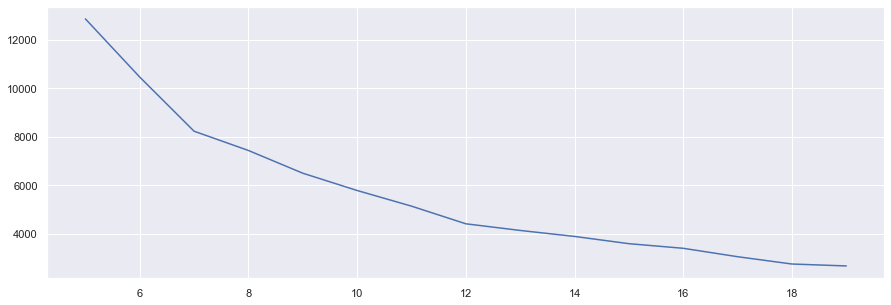

In [11]:
#Elbow
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

#prep data for kmeans
data=pd.DataFrame(data=scale(piv_fare),columns=new_colnames,index=piv.index)

#Optimize K selection.
kvals=list(range(5,20))
ss = []
for k in kvals:
    model=KMeans(n_clusters=k)
    model.fit(data.values)
    ss.append(model.inertia_)
    
plt.plot(kvals,ss) ;

#### Result:
We see an elbow near 7 clusters.

For n_clusters = 2 The average silhouette_score is : 0.9558251058872239
For n_clusters = 3 The average silhouette_score is : 0.9489721069108722
For n_clusters = 4 The average silhouette_score is : 0.7622489377010148
For n_clusters = 5 The average silhouette_score is : 0.7756938392262213
For n_clusters = 6 The average silhouette_score is : 0.5125741255503897
For n_clusters = 7 The average silhouette_score is : 0.515920636639795
For n_clusters = 8 The average silhouette_score is : 0.5159668291931737
For n_clusters = 9 The average silhouette_score is : 0.5104653288074715
For n_clusters = 10 The average silhouette_score is : 0.4637117356241508
For n_clusters = 11 The average silhouette_score is : 0.4898527501273835
For n_clusters = 12 The average silhouette_score is : 0.4880113647176186
For n_clusters = 13 The average silhouette_score is : 0.49597697714782113
For n_clusters = 14 The average silhouette_score is : 0.48727639412834006
For n_clusters = 15 The average silhouette_score is : 0.45

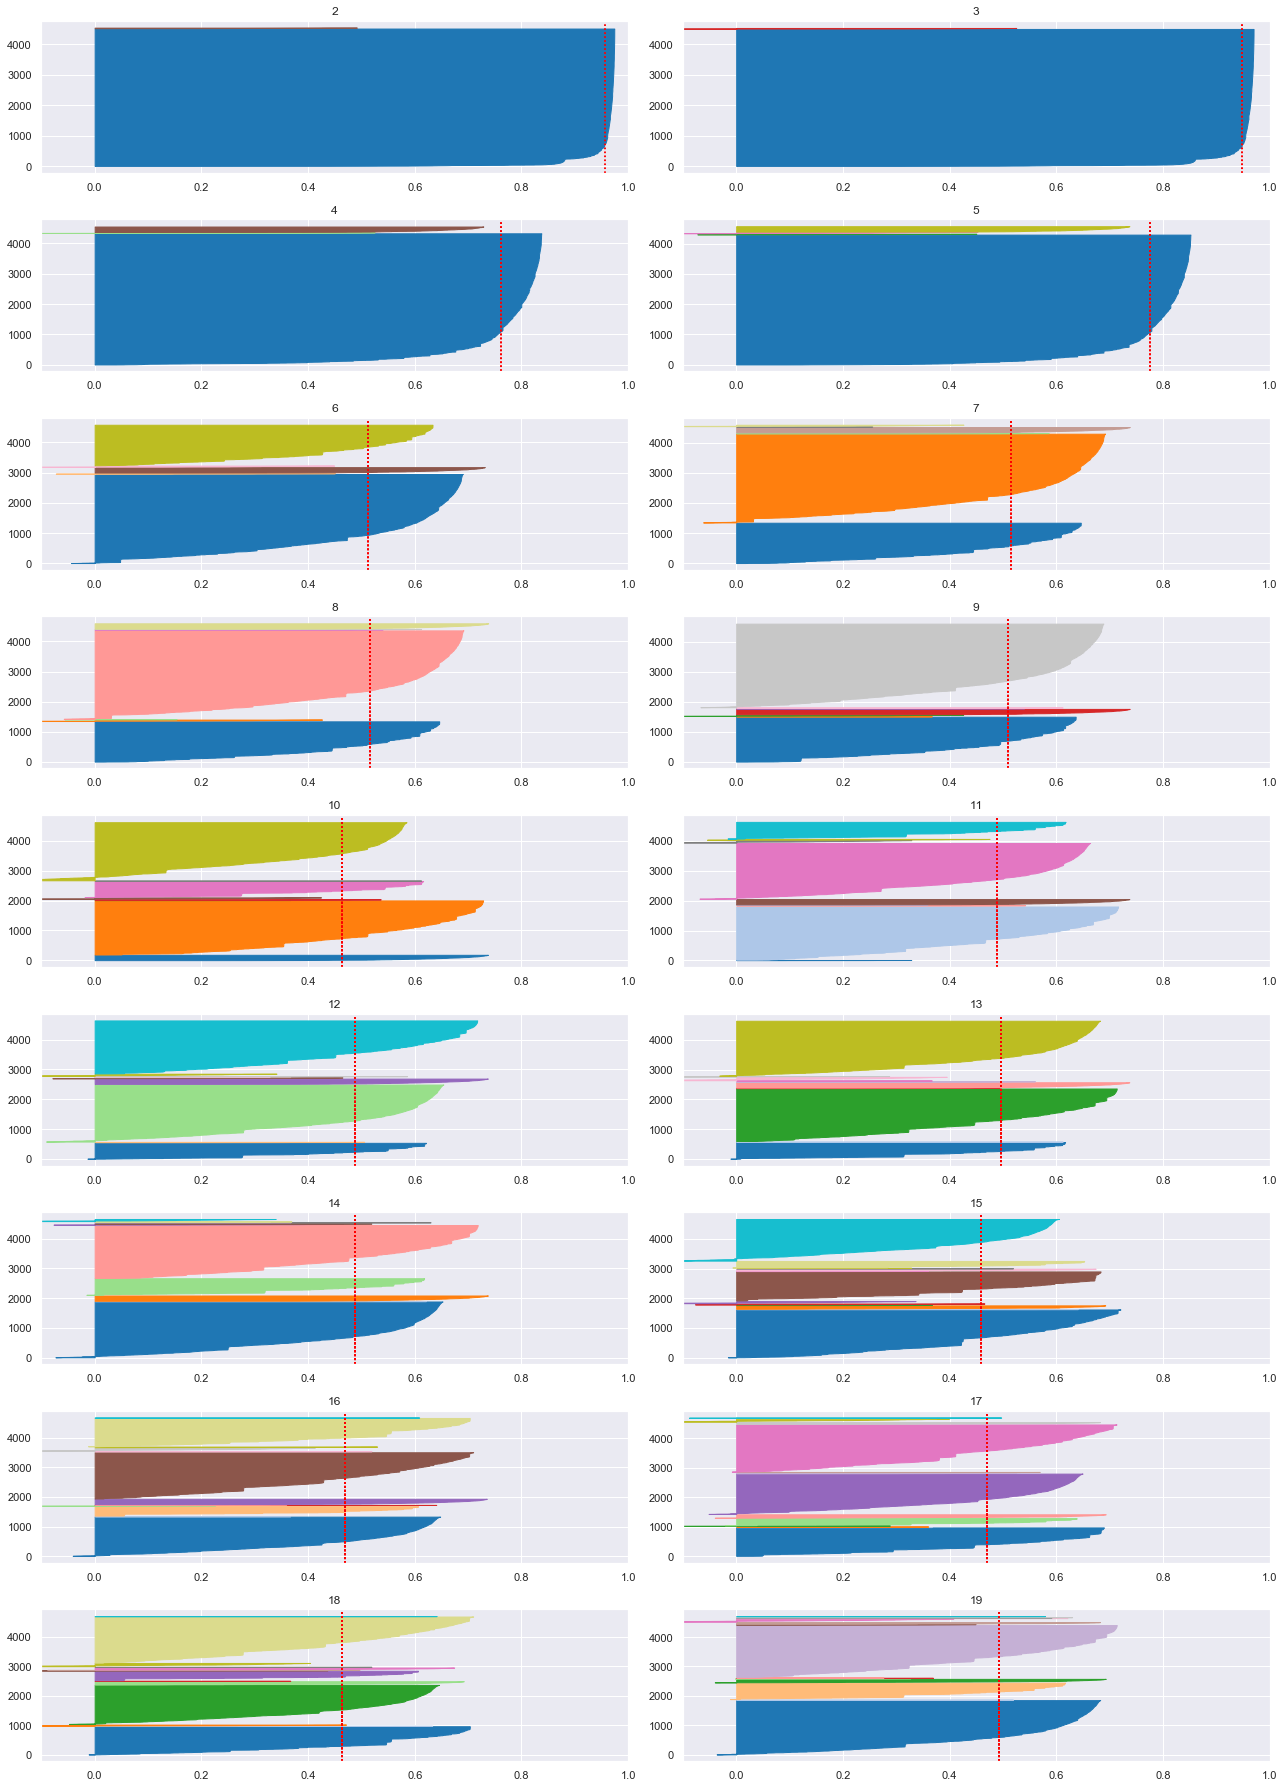

In [12]:
#Silhouette score and plots
from sklearn.metrics import silhouette_samples,silhouette_score
import matplotlib.cm as cm
fig,axs=plt.subplots(9,2,figsize=[18,25])
axs_reshaped =  axs.reshape(-1)
axix=0
kvals=list(range(20))[2:] 
for k in kvals:
    #print('k'+str(k))
    model=KMeans(n_clusters=k)
    labels=model.fit_predict(data.values)
    silhouette_avg=silhouette_score(data.values,labels)
    print("For n_clusters =", k, "The average silhouette_score is :", silhouette_avg)
    silhouette_vals=silhouette_samples(data.values,labels)
    #loop over clusters and plot fill between
    y_lower=10
    
    for i in range(k):
        #print('i'+str(i))
        icsv = silhouette_vals[labels==i]
        icsv.sort()
        size_i=icsv.shape[0]
        y_upper=y_lower+size_i
        color = cm.tab20(float(i) / k)#nipy_spectral
        
        axs_reshaped[axix].fill_betweenx(np.arange(y_lower,y_upper),0,icsv,facecolor=color,edgecolor=color)
        y_lower=y_upper+10
        axs_reshaped[axix].set_xlim([-0.1,1])#axs_reshaped[axix].set_xlim([-0.1,1])
        axs_reshaped[axix].axvline(x=silhouette_avg,color='red',linestyle=':')
        axs_reshaped[axix].set_title(k)
    axix+=1

plt.tight_layout()

**Result:** The silhouette score stabilizes after 5 clusters.  For larger K we begin to see more structures apparent in the data, and the larger clusters break off into smaller groupings.
<a id='fit'></a>

## 4.  Clustering with K-Means:  Fit model with 7 clusters

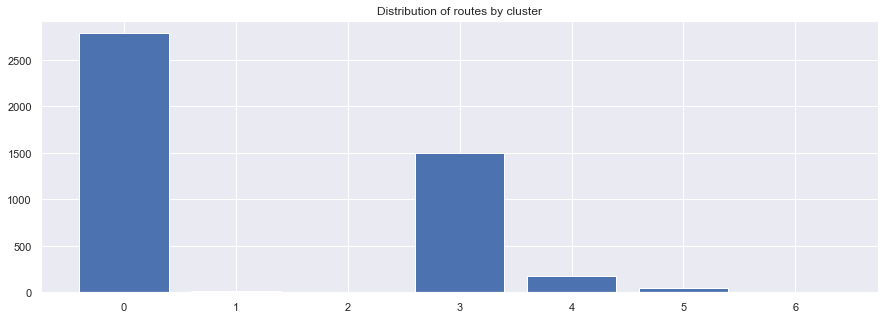

In [13]:
k=7
model=KMeans(n_clusters=k,random_state=40)
clust=model.fit(data.values)

results_df=piv_fare.copy()
results_df.columns=new_colnames
results_df['cluster']=clust.labels_
results_df=results_df.reset_index()
results_df['PUCommunityArea']=results_df['PUCommunityArea'].astype(int)
results_df['DOCommunityArea']=results_df['DOCommunityArea'].astype(int)

clfreq=np.bincount(clust.labels_)
clust_vals=range(k)
plt.bar(clust_vals,clfreq);
plt.title('Distribution of routes by cluster');

#### Results:
We see most of the data falling into two clusters.  We'll plot the data to see what it means.

<a id='viz'></a>

## 5.  Visualization of Results
The following dashboard show results for KMeans for k=7. The results of a model using higher k is shown [below.](#below)

In [14]:
#rework for plotting
from shapely.geometry import LineString

ca_gdf=gpd.read_file('CommAreas.shp')
ca_gdf['area_num_1']=ca_gdf['area_num_1'].astype(int)
ca_gdf=ca_gdf.set_index('area_num_1')
centroid=ca_gdf.centroid.to_dict()
#ca_gdf.plot()
mdf=ca_gdf.merge(results_df,left_index=True,right_on='PUCommunityArea')

results_df['PUCentroid']=results_df['PUCommunityArea'].apply(lambda area:centroid[area])
results_df['DOCentroid']=results_df['DOCommunityArea'].apply(lambda area:centroid[area])
results_df['geometry']=results_df.apply(lambda row: LineString([row['PUCentroid'],row['DOCentroid']]),axis=1)
results_gdf=gpd.GeoDataFrame(results_df,geometry='geometry')

results_gdf['X0']=results_gdf.PUCentroid.apply(lambda pt:pt.x)
results_gdf['Y0']=results_gdf.PUCentroid.apply(lambda pt:pt.y)
results_gdf['dx']=results_gdf.apply(lambda row:row.DOCentroid.x-row.PUCentroid.x,axis=1)
results_gdf['dy']=results_gdf.apply(lambda row:row.DOCentroid.y-row.PUCentroid.y,axis=1)



In [15]:
#plot
import ipywidgets as widgets
import matplotlib.gridspec as gridspec

plotcolor=sns.color_palette()[3] #color to be used to plot routes, matches seaborn palette
clust_slider = widgets.IntSlider(value=1,min=0,max=k-1,    step=1,    description='Cluster #: ',
    orientation='horizontal',layout={'width': '500px'})

def map_cluster(clust_id):
    plot_df=results_gdf.loc[results_gdf['cluster']==clust_id]
    #fig,ax=plt.subplots(1,2,figsize=[15,5])
    fig=plt.figure(figsize=(20,8))
    spec=gridspec.GridSpec(ncols=4,nrows=2, figure=fig)
    ax0=fig.add_subplot(spec[:,0:2])
    ax1=fig.add_subplot(spec[0,2:4])
    ax2=fig.add_subplot(spec[1,2:4])
    #Plot clustered routes on map
    ca_gdf.plot(ax=ax0,color='white',edgecolor='black')
    if plot_df.shape[0]>100:
        plot_df.plot(ax=ax0,column='cluster',color=plotcolor,linewidth=0.2)
    else:
        for row in plot_df.itertuples():
            ax0.arrow(row.X0,row.Y0,row.dx,row.dy,head_width=0.008,fc=plotcolor, ec=plotcolor,linewidth=0.3)

    #ax0.scatter(pupoints.apply(lambda pt:pt.x),pupoints.apply(lambda pt:pt.y),color='black')
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax0.set_title('Routes in Cluster {}'.format(clust_id))

    #bar plot
    weekday_bars=plot_df.loc[:,['False_earlymorning',
           'False_morning', 'False_midday', 'False_afternoon', 'False_evening',
           'False_lateevening']].mean().values
    weekday_std=plot_df.loc[:,['False_earlymorning',
           'False_morning', 'False_midday', 'False_afternoon', 'False_evening',
           'False_lateevening']].std().values                                                          
    weekend_bars=(plot_df.loc[:,['True_earlymorning',
           'True_morning', 'True_midday', 'True_afternoon', 'True_evening',
           'True_lateevening']].mean().values)*-1
    weekend_std=(plot_df.loc[:,['True_earlymorning',
           'True_morning', 'True_midday', 'True_afternoon', 'True_evening',
           'True_lateevening']].std().values)*-1
    x=[1,2,3,4,5,6]                                                          

    ax1.bar(x,weekday_bars,yerr=weekday_std,label='weekday')
    ax1.bar(x,weekend_bars,yerr=weekend_std,label='weekend')    

    #ax[1].set_ylim(-10000,10000)                    
    ax1.axhline(0,color='k')

    ax1.set_xticks(x)
    ax1.set_xticklabels(['Early Morning','Morning','MidDay','Afternoon','Evening','Late Evening'])             
    ax1.legend()  
    ax1.set_title('Temporal Distribution of Rideshare Usage in Cluster {}'.format(clust_id))
    ax1.set_ylabel('Average Ride Count')
    
    #fare distribution plot
    ax2.hist(plot_df.MeanFare,bins=list(range(0,70,2)))
    ax2.set_title('Distribution of Fares')
    ax2.set_xlabel('Average Fare ($)')
    ax2.set_ylabel('Frequency')


widgets.interact(
    map_cluster,
    clust_id=clust_slider
);

interactive(children=(IntSlider(value=1, description='Cluster #: ', layout=Layout(width='500px'), max=6), Outp…

<a id='results'></a>

<a id='findings'></a>

## 6.  Findings
From the results we find the following patterns of behavior:
* The most significant patterns are associated with commuting near the downtown area.  KMeans identifies one cluster (6) associated with heavy morning commute period usage, and one cluster (1) associated with heavy evening commute usage.  Cluster 2 represents very heavy usage, particulary during commute periods, within the city center.  Clusters 1, 2, and 6 all represent groups of rides with relatively low fares.
* Cluster 4 illustrates evening airport pickups, with a weekday evening peak, and a wide distribution of fares.  
* Cluster 5 identifies other heavily utilized commute patterns with higher fares relative to those in the immediate downtown corridor. Cluster 2 also includes an isolated set of rides in the southeast area of the city (Community Area 41) which appears to represent rideshare use to and from the University of Chicago.  
* The remaining clusters contain routes with low frequency of usage and higher fare.  Routes in cluster 0 exhibit a commute pattern with fares ranging between 5 and 20 dollars, while routes in cluster 3 have average fares generally exceeding 20 dollars but no commute usage pattern. 


<a id='below'></a>

---
## Bonus:  results with higher K
Using a higher K reveals more clusters, however they become more challenging to interpret.

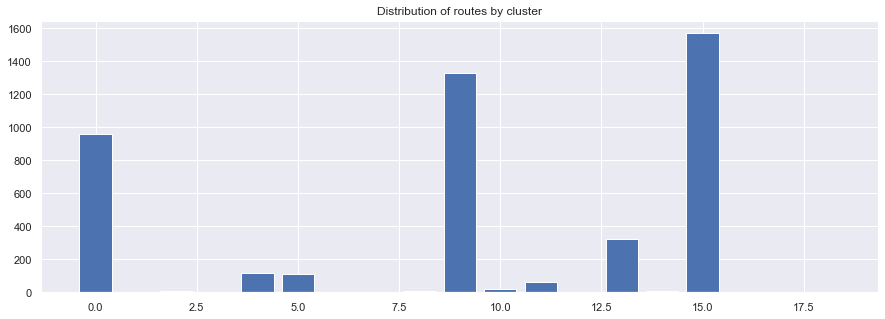

In [17]:
k=19
model=KMeans(n_clusters=k,random_state=40)
clust=model.fit(data.values)

results_df_bigK=piv_fare.copy()
results_df_bigK.columns=new_colnames
results_df_bigK['cluster']=clust.labels_
results_df_bigK=results_df_bigK.reset_index()
results_df_bigK['PUCommunityArea']=results_df_bigK['PUCommunityArea'].astype(int)
results_df_bigK['DOCommunityArea']=results_df_bigK['DOCommunityArea'].astype(int)

clfreq=np.bincount(clust.labels_)
clust_vals=range(k)
plt.bar(clust_vals,clfreq);
plt.title('Distribution of routes by cluster');

In [19]:
#rework for plotting 
from shapely.geometry import LineString

mdfbk=ca_gdf.merge(results_df_bigK,left_index=True,right_on='PUCommunityArea')

results_df_bigK['PUCentroid']=results_df_bigK['PUCommunityArea'].apply(lambda area:centroid[area])
results_df_bigK['DOCentroid']=results_df_bigK['DOCommunityArea'].apply(lambda area:centroid[area])
results_df_bigK['geometry']=results_df_bigK.apply(lambda row: LineString([row['PUCentroid'],row['DOCentroid']]),axis=1)
results_gdf_bigK=gpd.GeoDataFrame(results_df_bigK,geometry='geometry')

results_gdf_bigK['X0']=results_gdf_bigK.PUCentroid.apply(lambda pt:pt.x)
results_gdf_bigK['Y0']=results_gdf_bigK.PUCentroid.apply(lambda pt:pt.y)
results_gdf_bigK['dx']=results_gdf_bigK.apply(lambda row:row.DOCentroid.x-row.PUCentroid.x,axis=1)
results_gdf_bigK['dy']=results_gdf_bigK.apply(lambda row:row.DOCentroid.y-row.PUCentroid.y,axis=1)

In [20]:
#plot 
#to-do:  generalize mapping function to take any input dataset
import ipywidgets as widgets
import matplotlib.gridspec as gridspec

plotcolor=sns.color_palette()[3] #color to be used to plot routes, matches seaborn palette
clust_slider = widgets.IntSlider(value=1,min=0,max=k-1,    step=1,    description='Cluster #: ',
    orientation='horizontal',layout={'width': '500px'})

def map_cluster(clust_id):
    plot_df=results_gdf_bigK.loc[results_gdf['cluster']==clust_id]
    fig=plt.figure(figsize=(20,8))
    spec=gridspec.GridSpec(ncols=4,nrows=2, figure=fig)
    ax0=fig.add_subplot(spec[:,0:2])
    ax1=fig.add_subplot(spec[0,2:4])
    ax2=fig.add_subplot(spec[1,2:4])
    #Plot clustered routes on map
    ca_gdf.plot(ax=ax0,color='white',edgecolor='black')
    if plot_df.shape[0]>100:
        plot_df.plot(ax=ax0,column='cluster',color=plotcolor,linewidth=0.2)
    else:
        for row in plot_df.itertuples():
            ax0.arrow(row.X0,row.Y0,row.dx,row.dy,head_width=0.008,fc=plotcolor, ec=plotcolor,linewidth=0.3)

    ax0.set_xticks([])
    ax0.set_yticks([])
    ax0.set_title('Routes in Cluster {}'.format(clust_id))

    #bar plot
    weekday_bars=plot_df.loc[:,['False_earlymorning',
           'False_morning', 'False_midday', 'False_afternoon', 'False_evening',
           'False_lateevening']].mean().values
    weekday_std=plot_df.loc[:,['False_earlymorning',
           'False_morning', 'False_midday', 'False_afternoon', 'False_evening',
           'False_lateevening']].std().values                                                          
    weekend_bars=(plot_df.loc[:,['True_earlymorning',
           'True_morning', 'True_midday', 'True_afternoon', 'True_evening',
           'True_lateevening']].mean().values)*-1
    weekend_std=(plot_df.loc[:,['True_earlymorning',
           'True_morning', 'True_midday', 'True_afternoon', 'True_evening',
           'True_lateevening']].std().values)*-1
    x=[1,2,3,4,5,6]                                                          

    ax1.bar(x,weekday_bars,yerr=weekday_std,label='weekday')
    ax1.bar(x,weekend_bars,yerr=weekend_std,label='weekend')    

    #ax[1].set_ylim(-10000,10000)                    
    ax1.axhline(0,color='k')

    ax1.set_xticks(x)
    ax1.set_xticklabels(['Early Morning','Morning','MidDay','Afternoon','Evening','Late Evening'])             
    ax1.legend()  
    ax1.set_title('Temporal Distribution of Rideshare Usage in Cluster {}'.format(clust_id))
    ax1.set_ylabel('Average Ride Count')
    
    #fare distribution plot
    ax2.hist(plot_df.MeanFare,bins=list(range(0,70,2)))
    ax2.set_title('Distribution of Fares')
    ax2.set_xlabel('Average Fare ($)')
    ax2.set_ylabel('Frequency')


widgets.interact(
    map_cluster,
    clust_id=clust_slider
);

interactive(children=(IntSlider(value=1, description='Cluster #: ', layout=Layout(width='500px'), max=18), Out…